In [1]:
!pip install -q transformers datasets scikit-learn torch pyvi
!pip install -q --upgrade transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 52.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 101.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import torch
import os
import shutil
import unicodedata
import re

from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)

from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score

from pyvi import ViTokenizer


2025-12-25 18:42:37.134456: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766688157.361311      25 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766688157.433906      25 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766688157.982798      25 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766688157.982842      25 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766688157.982846      25 computation_placer.cc:177] computation placer alr

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cuda


In [4]:
def clean_text_phobert(text):
    if pd.isna(text):
        return ""
    text = unicodedata.normalize("NFC", text)
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return ViTokenizer.tokenize(text)


In [5]:
train_df = pd.read_csv("/kaggle/input/nlp-final-prj2/train_data1.csv")
val_df   = pd.read_csv("/kaggle/input/nlp-final-prj2/val_data1.csv")

train_df["text"] = train_df["text"].apply(clean_text_phobert)
val_df["text"]   = val_df["text"].apply(clean_text_phobert)

train_texts = train_df["text"].tolist()
val_texts   = val_df["text"].tolist()

train_labels = train_df["label"].tolist()
val_labels   = val_df["label"].tolist()


In [6]:
le = LabelEncoder()
train_labels = le.fit_transform(train_labels)
val_labels   = le.transform(val_labels)

classes = np.unique(train_labels)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

print("Class weights:", class_weights)


Class weights: tensor([0.6297, 2.4281], device='cuda:0')


In [7]:
class PhoBERTDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }


In [8]:
model_name = "vinai/phobert-base"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(classes)
)

model.to(device)


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [9]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)

    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
        "f1_weighted": f1_score(labels, preds, average="weighted")
    }


In [10]:
training_args = TrainingArguments(
    output_dir="./phobert_ckpt",
    eval_strategy="epoch",     
    save_strategy="epoch",      
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    save_total_limit=3,
    report_to=[]
)


model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

In [11]:
import torch.nn as nn

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        loss_fct = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss


In [12]:
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=PhoBERTDataset(train_texts, train_labels, tokenizer),
    eval_dataset=PhoBERTDataset(val_texts, val_labels, tokenizer),
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

train_result = trainer.train()


/tmp/ipykernel_25/3832015832.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,No log,0.219341,0.950853,0.939621,0.949573
2,0.248400,0.173076,0.970913,0.965062,0.970526
3,0.248400,0.328486,0.954865,0.944784,0.953800
4,0.112200,0.157896,0.979940,0.976205,0.979807
5,0.112200,0.427391,0.958877,0.950004,0.958053
6,0.046400,0.338427,0.964895,0.957580,0.964312
7,0.046400,0.346199,0.965898,0.958916,0.965388
8,0.022400,0.421026,0.960883,0.952732,0.960233
9,0.022400,0.339910,0.970913,0.965198,0.970587
10,0.012600,0.365184,0.968907,0.962726,0.968526


In [13]:
# Zip checkpoints
for d in os.listdir("./phobert_ckpt"):
    if d.startswith("checkpoint"):
        path = os.path.join("./phobert_ckpt", d)
        shutil.make_archive(path, "zip", path)

# Save final
final_path = "./phobert_ckpt/final"
trainer.save_model(final_path)
tokenizer.save_pretrained(final_path)
shutil.make_archive(final_path, "zip", final_path)


'/kaggle/working/phobert_ckpt/final.zip'

In [14]:
print("\n***** FINAL EVAL *****")
eval_results = trainer.evaluate()
for k, v in eval_results.items():
    print(f"{k}: {v}")



***** FINAL EVAL *****


eval_loss: 0.15789636969566345
eval_accuracy: 0.9799398194583752
eval_f1_macro: 0.9762047962729599
eval_f1_weighted: 0.9798074388897782
eval_runtime: 12.8393
eval_samples_per_second: 77.652
eval_steps_per_second: 2.492
epoch: 10.0


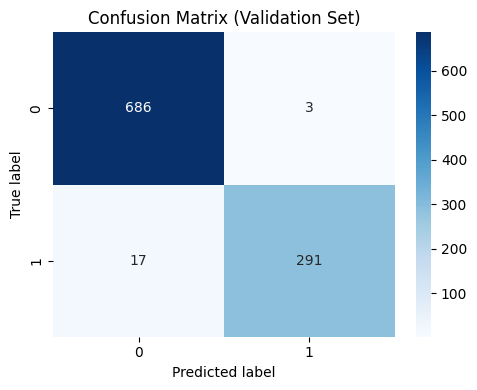


Classification Report (Validation):
              precision    recall  f1-score   support

           0     0.9758    0.9956    0.9856       689
           1     0.9898    0.9448    0.9668       308

    accuracy                         0.9799       997
   macro avg     0.9828    0.9702    0.9762       997
weighted avg     0.9801    0.9799    0.9798       997



In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Lấy prediction trên val
pred_output = trainer.predict(
    PhoBERTDataset(val_texts, val_labels, tokenizer)
)

y_true = pred_output.label_ids
y_pred = np.argmax(pred_output.predictions, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix (Validation Set)")
plt.tight_layout()
plt.show()

# In thêm classification report cho dễ đọc
print("\nClassification Report (Validation):")
print(classification_report(
    y_true,
    y_pred,
    target_names=le.classes_.astype(str),
    digits=4
))
